In [1]:
import pandas as pd

# Load the TRUE and FAKE news datasets
true_df = pd.read_csv("true.csv")  # Change path if needed
fake_df = pd.read_csv("fake.csv")  # Change path if needed

# Display first few rows
print("TRUE News Data:")
print(true_df.head())

print("\nFAKE News Data:")
print(fake_df.head())


TRUE News Data:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  December 30, 2017   
4  December 29, 2017   

FAKE News Data:
                                               title  \
0   Donal

In [2]:
# Add a label column
true_df["label"] = 0  # Real news = 0
fake_df["label"] = 1  # Fake news = 1

# Combine both datasets
df = pd.concat([true_df, fake_df], ignore_index=True)

# Shuffle the dataset to avoid order bias
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check dataset structure
print(df.head())


                                               title  \
0   BREAKING: GOP Chairman Grassley Has Had Enoug...   
1   Failed GOP Candidates Remembered In Hilarious...   
2   Mike Pence’s New DC Neighbors Are HILARIOUSLY...   
3  California AG pledges to defend birth control ...   
4  AZ RANCHERS Living On US-Mexico Border Destroy...   

                                                text       subject  \
0  Donald Trump s White House is in chaos, and th...          News   
1  Now that Donald Trump is the presumptive GOP n...          News   
2  Mike Pence is a huge homophobe. He supports ex...          News   
3  SAN FRANCISCO (Reuters) - California Attorney ...  politicsNews   
4  Twisted reasoning is all that comes from Pelos...      politics   

               date  label  
0     July 21, 2017      1  
1       May 7, 2016      1  
2  December 3, 2016      1  
3  October 6, 2017       0  
4      Apr 25, 2017      1  


In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    if pd.isna(text):  # Handle NaN values
        return ""
    text = re.sub(r'[^a-zA-Z]', ' ', text)  # Remove special characters & numbers
    text = text.lower()  # Convert to lowercase
    words = text.split()
    words = [stemmer.stem(word) for word in words if word not in stop_words]  # Apply stemming
    return ' '.join(words)

# Apply preprocessing to text column
df['clean_text'] = df['text'].apply(preprocess_text)

print(df['clean_text'].head())  # Check cleaned text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    donald trump white hous chao tri cover russia ...
1    donald trump presumpt gop nomine time rememb c...
2    mike penc huge homophob support ex gay convers...
3    san francisco reuter california attorney gener...
4    twist reason come pelosi day especi promin dem...
Name: clean_text, dtype: object


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)  # Limit vocabulary size
X = vectorizer.fit_transform(df['clean_text']).toarray()

# Extract target variable
y = df['label']


In [5]:
from sklearn.model_selection import train_test_split

# Split into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Train Logistic Regression
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train, y_train)


RandomForestClassifier()

In [7]:
from sklearn.metrics import accuracy_score, classification_report

# Predict on test data
log_preds = log_model.predict(X_test)
rf_preds = rf_model.predict(X_test)

# Calculate accuracy
log_accuracy = accuracy_score(y_test, log_preds)
rf_accuracy = accuracy_score(y_test, rf_preds)

# Print classification report
print("\nLogistic Regression:")
print(classification_report(y_test, log_preds))

print("\nRandom Forest:")
print(classification_report(y_test, rf_preds))



Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4311
           1       0.99      0.98      0.99      4669

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980


Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4311
           1       1.00      1.00      1.00      4669

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



In [8]:
def predict_news(news_text, model):
    news_text = preprocess_text(news_text)
    news_vector = vectorizer.transform([news_text]).toarray()
    prediction = model.predict(news_vector)[0]
    return "FAKE NEWS" if prediction == 1 else "REAL NEWS"

# Example Test Cases
news1 = "Breaking: Scientists discover a new planet that can sustain human life!"
news2 = "Government announces new tax reforms for middle class."

print("News 1:", predict_news(news1, rf_model))
print("News 2:", predict_news(news2, rf_model))


News 1: FAKE NEWS
News 2: FAKE NEWS


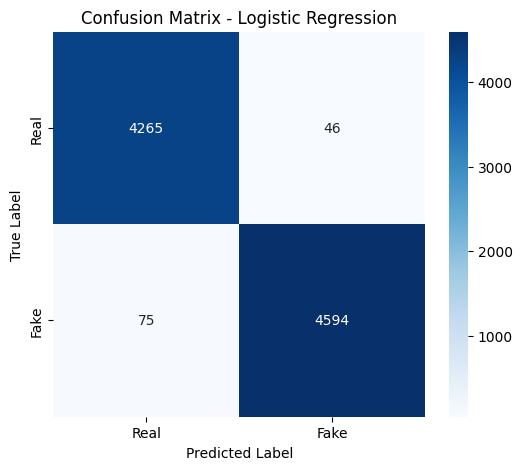

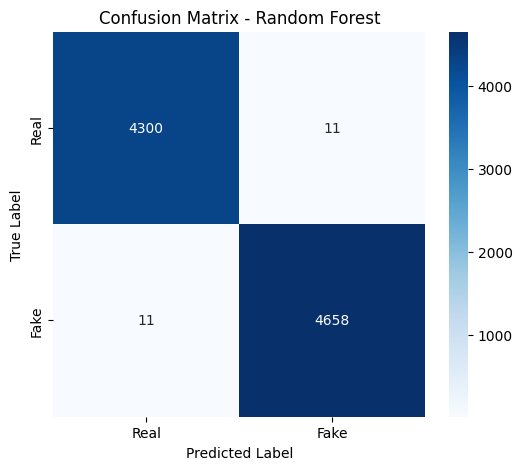

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_preds, model_name):
    cm = confusion_matrix(y_test, y_preds)
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Plot confusion matrix for Logistic Regression
plot_confusion_matrix(y_test, log_preds, "Logistic Regression")

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf_preds, "Random Forest")


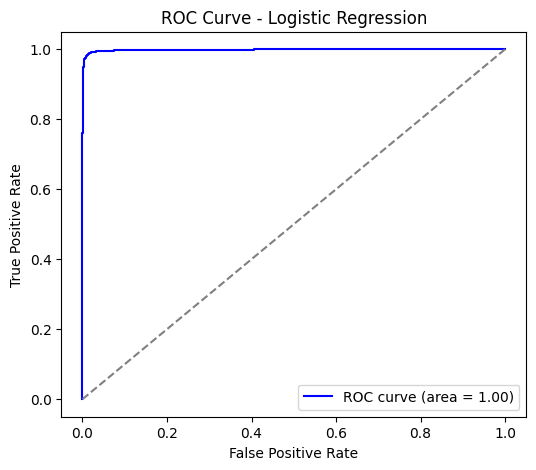

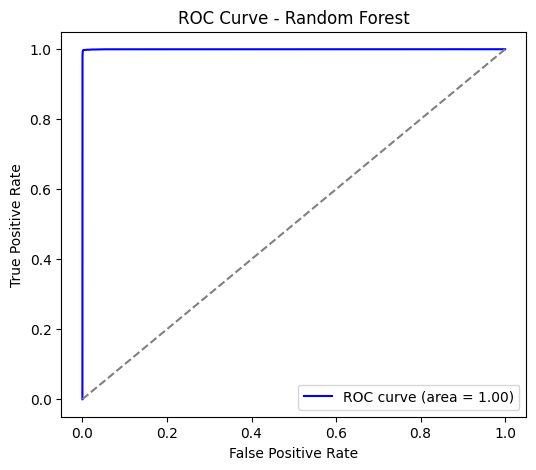

In [10]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, y_probs, model_name):
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.show()

# Get prediction probabilities
log_probs = log_model.predict_proba(X_test)[:, 1]
rf_probs = rf_model.predict_proba(X_test)[:, 1]

# Plot ROC curve for Logistic Regression
plot_roc_curve(y_test, log_probs, "Logistic Regression")

# Plot ROC curve for Random Forest
plot_roc_curve(y_test, rf_probs, "Random Forest")


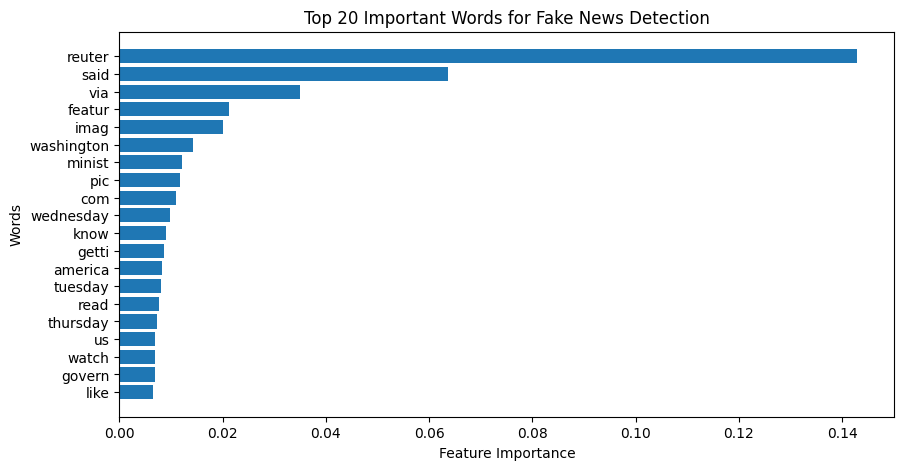

In [11]:
import numpy as np

# Get feature importance from Random Forest
feature_importances = rf_model.feature_importances_

# Get top 20 important words
feature_names = vectorizer.get_feature_names_out()
top_indices = np.argsort(feature_importances)[-20:]

plt.figure(figsize=(10, 5))
plt.barh(range(len(top_indices)), feature_importances[top_indices], align='center')
plt.yticks(range(len(top_indices)), [feature_names[i] for i in top_indices])
plt.xlabel("Feature Importance")
plt.ylabel("Words")
plt.title("Top 20 Important Words for Fake News Detection")
plt.show()


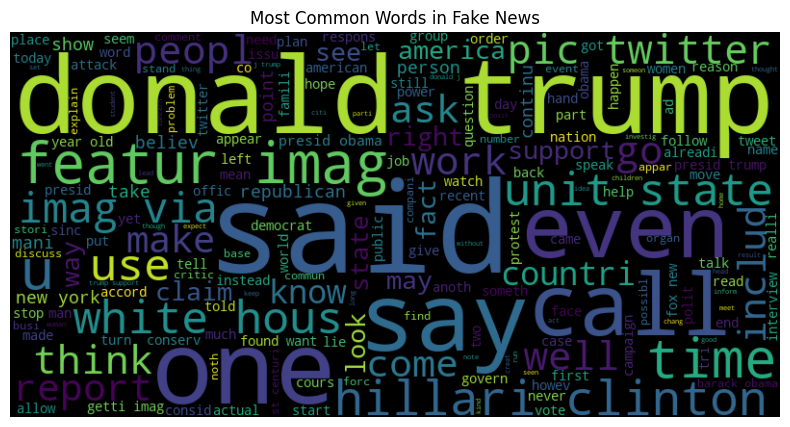

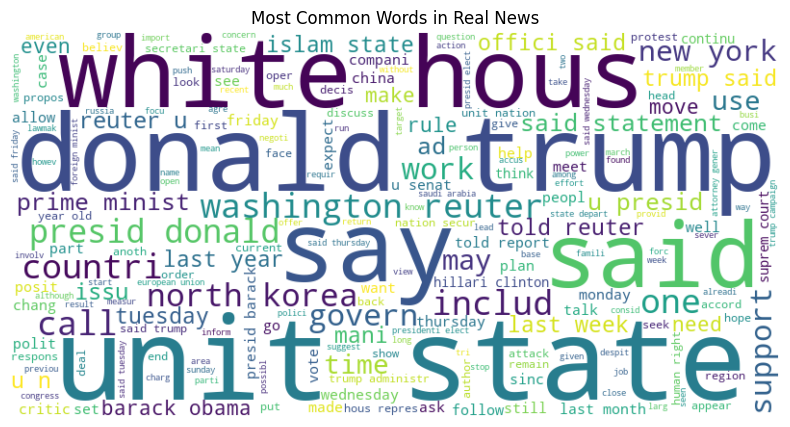

In [12]:
from wordcloud import WordCloud

# Generate word cloud for Fake news
fake_text = " ".join(df[df['label'] == 1]['clean_text'])
wordcloud_fake = WordCloud(width=800, height=400, background_color='black').generate(fake_text)

# Generate word cloud for Real news
real_text = " ".join(df[df['label'] == 0]['clean_text'])
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(real_text)

# Plot Fake news WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_fake, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Fake News")
plt.show()

# Plot Real news WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in Real News")
plt.show()
